In [1]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

import tensorflow as tf
from mat4py import loadmat
import numpy as np
import pandas as pd
from Utilities.plotting_sine import plot_solution
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.Net import Final_Network
from Utilities.create_data import create_new
from Utilities.L2_error_computation import error_L2
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.model_constraint import compute_interior_loss
from Utilities.optimize_layerwise import optimize

from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [2]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers =5 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  =100
    activation        = 'elu'
    classification_act= 'linear'
    model_constraint  =  40
    regularization    = 0.2
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 2000
    
    num_networks      = 6
    

In [3]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [4]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



In [ ]:
if __name__ == "__main__":     
    
    # Just put a for loop here for trainable from 2 to max_hidden_layer
    
    trainable=2
    
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
   

    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    
    gauss_solution=np.loadtxt("gauss_solution.data")
    gauss_solution = tf.cast(gauss_solution,tf.float32)
    

    
    gauss_points_new = loadmat('gauss_points_new.mat')
    gauss_points_new=np.array(list(gauss_points_new.values()))[-1]
    gauss_points_new = tf.cast(gauss_points_new,tf.float32)
    

    
    gauss_weights_new = loadmat('gauss_weights_new.mat')
    gauss_weights_new=np.array(list(gauss_weights_new.values()))[-1].squeeze(-1)

    
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))
    
    Solution = loadmat('Solution.mat')
    Solution=np.array(list(Solution.values()))[-1]
    Solution=tf.cast(Solution,tf.float32)
    Solution=tf.reshape(Solution,(len(Solution),1))
    
    

    
    
    for i in range(1,2):
        
    #=== Initiate training ===#
       

    
            
        if trainable==2:
        
        
        
            #=== GPU Settings ===#
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
            os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
            if run_options.use_L1 == 0:
                kernel_regularizer = None
                bias_regularizer = None  
            else:
                kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
                bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            
            


            data_train,new_label,labels_train,load,Solution=create_new(data_train, labels_train,hyperp,run_options, data_input_shape, label_dimensions,i,load,Stiffness,Coordinates,Solution)
        
            
        #=== Construct Validation Set and Batches ===# 
            data_and_labels_train, data_and_labels_val, data_and_labels_test,\
            num_data_train, num_data_val, num_data_test,\
            num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
            = form_train_val_test_batches(data_train, labels_train, \
                                      data_test, labels_test, \
                                      hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if trainable==2:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
            NN._set_inputs( data_train)
       
    #                                 Training                                    #
###############################################################################
        if trainable>2:
            del NN
            NN = Final(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer,trainable)   
            #NN._set_inputs(data_train)
            NN.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable-1))
            #NN=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(1)+str(trainable-1))
        


        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,trainable,compute_interior_loss,error_L2,gauss_solution,gauss_points_new,gauss_weights_new,Coordinates, Stiffness, load,Solution)   
        
        
        #NN.save("WEIGHTS"+'/'+"model"+str(1)+str(trainable))
        if not os.path.exists("WEIGHTS"):
            os.makedirs("WEIGHTS")
        NN.save_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable))
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i,trainable+1)
            

        
        
        
        
        
        
        
        
        

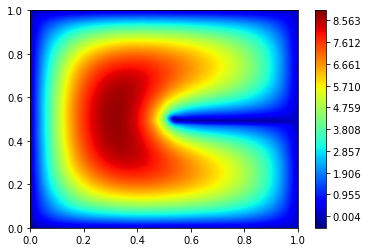

In [6]:
trainable=2
    #=== Hyperparameters and Run Options ===#    
hyperp = Hyperparameters()

run_options = RunOptions()
    
plot_layer=5



#=== File Names ===#
file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
data_train, labels_train,\
data_test, labels_test,\
data_input_shape, num_channels, label_dimensions\
= load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed)    


plot_solution(hyperp, data_test, run_options, data_input_shape, label_dimensions,plot_layer,data_train, labels_train,labels_test)
        

In [7]:
# Evaluating the Final stored model

hyperp = Hyperparameters()
  
run_options = RunOptions()

file_paths = FilePaths(hyperp, run_options)

#=== Load Boundary Data ===#       
data_train, labels_train,    data_test, labels_test,    data_input_shape, num_channels, label_dimensions    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    

Network=Final_Network(hyperp,run_options, data_input_shape, label_dimensions) 

Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(hyperp.max_hidden_layers)).expect_partial()





# Loading Gauss quadrature data for interior domain

gauss_weights_new = loadmat('gauss_weights_new.mat')
gauss_weights_new=np.array(list(gauss_weights_new.values()))[-1].squeeze(-1)

gauss_solution=np.loadtxt("gauss_solution.data")
gauss_solution = tf.cast(gauss_solution,tf.float32)
    

    
gauss_points_new = loadmat('gauss_points_new.mat')
gauss_points_new=np.array(list(gauss_points_new.values()))[-1]
gauss_points_new = tf.cast(gauss_points_new,tf.float32)
    

L2_error=error_L2(gauss_points_new, gauss_solution, Network,label_dimensions,hyperp,data_input_shape,1,run_options,gauss_weights_new)

print('L2 error: %.3e' %(L2_error))

L2 error: 7.859e-05
